In [1]:
#importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
upload = files.upload()

Saving RSCCASN.csv to RSCCASN.csv


In [3]:
# reading the data into the pandas dataframe

df = pd.read_csv('RSCCASN.csv')
df.head()

,DATE,RSCCASN
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


In [4]:
df.info()   # here the date column is of object/string type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   DATE     334 non-null    object
 1   RSCCASN  334 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


In [5]:
# we convert that date column to date-time object and also make that column as index

df = pd.read_csv('RSCCASN.csv', parse_dates=True, index_col='DATE')   # pandas automatically converts the objects to date-time object when parse_dates is specified as True

In [6]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [9]:
df.columns = ['sales']
df[:5]

,sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


***Note:-***

We should be dping a train/test split atleast a year's worth of information because there is clearly a yearly cycle(seasonal data). We should try to forecast atleast one of these seasonalities.

In [10]:
len(df)   # monthly data --> eg:- 12 rows ---> 1 year data

334

In [11]:
test_size = 18    # we are taking 18 months as our test size i.e 1.5 year

In [12]:
len(df)-18        # then these many months will be considered as train data

316

In [13]:
test_ind = len(df)-18

In [14]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [18]:
train.tail()

,sales
DATE,
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616


In [16]:
test[:5]

,sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260


In [19]:
# scale our data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [20]:
scaled_train[:5]

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053]])

In [21]:
scaled_test[:5]

array([[0.61087714],
       [0.53191258],
       [0.54389341],
       [0.59697212],
       [0.4836625 ]])

In [22]:
# let's create our batches for the model to train 

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
# define our batches
len(test)     # so our batches should be less than the test length i,e 18

18

In [24]:
# ideally, 12 is good length as it covers entire year's seasonal data as well

length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [25]:
X,y = generator[0]

In [26]:
X       # given the length of 12 months data, we predict the 13th month data now

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [27]:
y     # and this is that 13th month data which we are trying to predict using the LSTM model

array([[0.02047633]])

In [28]:
# LSTM modelling

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

n_features = 1    # 'Sales' column only

model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [30]:
# implement early stopping method

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience = 2)  # because time series can be noisy at times, so wait for 2 extra epochs after the early stop is encountered

In [32]:
# create the validation generator

validation_gen = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [33]:
X,y = validation_gen[0]
X

array([[[0.61087714],
        [0.53191258],
        [0.54389341],
        [0.59697212],
        [0.4836625 ],
        [0.52770113],
        [0.68592071],
        [1.00813244],
        [0.34388615],
        [0.40647691],
        [0.55021057],
        [0.53220302]]])

In [34]:
y

array([[0.59040081]])

In [35]:
model.fit(generator, epochs=20, validation_data=validation_gen, callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 10s 21ms/step - loss: 0.0242 - val_loss: 0.0642
Epoch 2/20
304/304 [==============================] - 8s 25ms/step - loss: 0.0207 - val_loss: 0.0115
Epoch 3/20
304/304 [==============================] - 6s 21ms/step - loss: 0.0149 - val_loss: 0.0071
Epoch 4/20
304/304 [==============================] - 8s 25ms/step - loss: 0.0081 - val_loss: 0.0041
Epoch 5/20
304/304 [==============================] - 6s 20ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 6/20
304/304 [==============================] - 6s 20ms/step - loss: 0.0026 - val_loss: 5.6264e-04
Epoch 7/20
304/304 [==============================] - 6s 20ms/step - loss: 0.0019 - val_loss: 3.2717e-04
Epoch 8/20
304/304 [==============================] - 6s 20ms/step - loss: 0.0015 - val_loss: 4.1853e-04
Epoch 9/20
304/304 [==============================] - 6s 20ms/step - loss: 0.0015 - val_loss: 3.7561e-04


In [36]:
loss = pd.DataFrame(model.history.history)

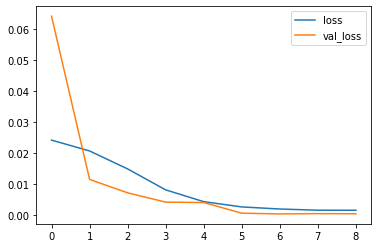

In [39]:
loss.plot()

In [42]:
test_pred = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_pred.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 20ms/step


In [44]:
true_pred = scaler.inverse_transform(test_pred)
test['Predictions'] = true_pred
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sales,Predictions
DATE,,
2018-05-01,23764,21280.818532
2018-06-01,21589,20372.166362
2018-07-01,21919,20621.411152
2018-08-01,23381,22233.363719
2018-09-01,20260,20066.818038
2018-10-01,21473,20666.703760
2018-11-01,25831,24180.737372
2018-12-01,34706,33435.574604
2019-01-01,16410,16410.099084


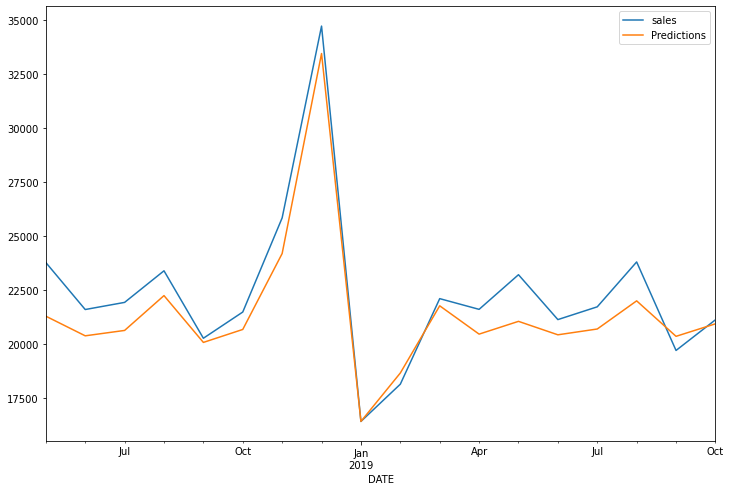

In [47]:
test.plot(figsize=(12,8))

In [48]:
# Forecasting will be done now

full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [50]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [51]:
# re-train the model now

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [54]:
# since we don't have any testing data we cannot create a validation data as well from it, so we cannot use callbacks here because we are passing the entire dataset for forecasting

model.fit(generator, epochs=7)

Epoch 1/7
322/322 [==============================] - 7s 23ms/step - loss: 0.0025
Epoch 2/7
322/322 [==============================] - 9s 29ms/step - loss: 0.0023
Epoch 3/7
322/322 [==============================] - 8s 24ms/step - loss: 0.0016
Epoch 4/7
322/322 [==============================] - 11s 35ms/step - loss: 0.0018
Epoch 5/7
322/322 [==============================] - 8s 25ms/step - loss: 0.0013
Epoch 6/7
322/322 [==============================] - 8s 25ms/step - loss: 0.0018
Epoch 7/7
322/322 [==============================] - 9s 29ms/step - loss: 0.0010


In [56]:
# time to forecast now

forecast = []
periods = 12    # number of months do u want to see the forecast for, here choosen to forecast for next 12 months or 1 year

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(periods):
  current_pred = model.predict(current_batch)[0]
  forecast.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

1/1 [==============================] - 0s 17ms/step


In [57]:
forecast = scaler.inverse_transform(forecast)
forecast      # these are the predictions for the next 12 months

array([[26523.45435619],
       [36678.27777958],
       [16313.34252763],
       [18318.61496878],
       [22059.53847694],
       [21832.74872732],
       [23487.93186426],
       [21428.86336899],
       [22080.99287033],
       [24156.81378603],
       [20158.67150664],
       [21688.84110165]])

In [58]:
df.tail()

,sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [60]:
forecast_index = pd.date_range(start='2019-11-01',
                               periods=periods,
                               freq='MS')

# start value is taken by looking at the last value of the dataset that was 01-10-2019, so the new predictions should start from 2019-11-01
# MS means month start frequency, specified periods as 12, so it means that generate the indexes for 12 months starting from 2019-11-01

In [61]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [62]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecasted Sales'])
forecast_df

,Forecasted Sales
2019-11-01,26523.454356
2019-12-01,36678.277780
2020-01-01,16313.342528
2020-02-01,18318.614969
2020-03-01,22059.538477
2020-04-01,21832.748727
2020-05-01,23487.931864
2020-06-01,21428.863369
2020-07-01,22080.992870
2020-08-01,24156.813786


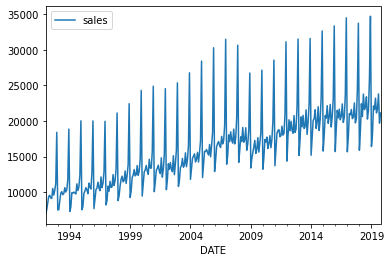

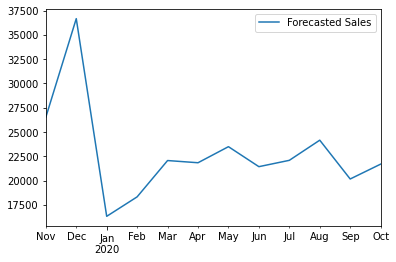

In [63]:
df.plot()
forecast_df.plot()

<Figure size 864x576 with 0 Axes>

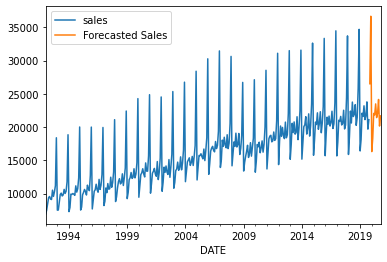

In [66]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

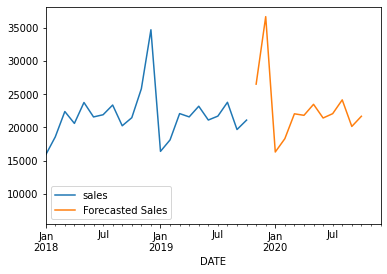

In [67]:
# zoomed in version

ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')

From the plot we can clearly see that we are able to identify the seasonal trend which was happening in Dec from the original sales and the forecasted sales. 

It tells that similar trend will be followed in the future too